### import the dependencies

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from torchdiffeq import odeint

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

DATA_PATH = os.path.join("..", "Dataset", "raw_RRI_segments.csv")
OUT_MODEL = os.path.join("..", "Two_Class_Models", "saved_models", "PSR_hybrid_two_class_best.pth")

### Load PSR dataset and preprocess

In [2]:
# Load CSV
df = pd.read_csv(DATA_PATH)
print("CSV loaded. Shape:", df.shape)

# Merge SR (0) + Pre-AF (1) → 0 (non-AF), keep AF (2) → 1 (AF)
mask_binary = df["label"].isin([0, 1, 2])
df = df[mask_binary].copy()

df["label"] = df["label"].map({
    0: 0,  # SR -> non-AF
    1: 0,  # Pre-AF -> non-AF
    2: 1   # AF -> AF
})

print("Merged SR+Pre-AF as non-AF, AF as positive class.")
print("Final shape:", df.shape)
print("Class distribution:\n", df["label"].value_counts())


CSV loaded. Shape: (14357, 55)
Merged SR+Pre-AF as non-AF, AF as positive class.
Final shape: (14357, 55)
Class distribution:
 label
0    9557
1    4800
Name: count, dtype: int64


### PSR

In [3]:
def phase_space_reconstruct(x, m=3, tau=1):
    """
    x: 1D array of RRI
    m: embedding dimension
    tau: time delay
    Returns flattened PSR embedding: x(t), x(t+tau), ..., x(t+(m-1)*tau)
    """
    x = np.asarray(x)
    N = len(x)
    if N < (m-1)*tau + 1:
        # pad with zeros if too short
        x = np.pad(x, (0, (m-1)*tau + 1 - N), 'constant')
        N = len(x)
    psr_vectors = [x[i:N-(m-1)*tau + i] for i in range(m)]
    psr_flat = np.column_stack(psr_vectors).flatten()
    return psr_flat

# Pick RRI columns
rri_cols = [f"r_{i}" for i in range(50)]

# Compute PSR for all rows with m=3, tau=2
psr_features = df[rri_cols].apply(lambda row: phase_space_reconstruct(row.values, m=3, tau=2), axis=1)
psr_features = np.stack(psr_features.values)  # shape: (num_samples, m*(N-(m-1)*tau))

# Add PSR columns to DataFrame
num_psr_cols = psr_features.shape[1]
psr_col_names = [f"psr_{i}" for i in range(num_psr_cols)]
df_psr = pd.DataFrame(psr_features, columns=psr_col_names, index=df.index)
df = pd.concat([df, df_psr], axis=1)

print("PSR features added (m=3, tau=2). DataFrame shape:", df.shape)




PSR features added (m=3, tau=2). DataFrame shape: (14357, 193)


### Extract features and labels

In [4]:
feature_cols = psr_col_names
meta_cols = ["patient_id", "record_id", "label", "label_str", "orig_len"]

# Feature matrix X and labels y
X = df[feature_cols].values.astype(np.float32)
y = df["label"].values.astype(int)

# Drop rows with NaN or inf
mask_good = np.isfinite(X).all(axis=1)
X = X[mask_good]
y = y[mask_good]

print("Loaded samples:", X.shape, "class counts:", np.bincount(y))


Loaded samples: (14357, 138) class counts: [9557 4800]


### Train / val / test split, scaling and SMOTE (apply SMOTE only to training set)

In [5]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=RANDOM_SEED
)

print("Splits -> train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)

# Standardize using training stats
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# SMOTE on training only
smote = SMOTE(random_state=RANDOM_SEED)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("After SMOTE train distribution:", np.bincount(y_train_res))

Splits -> train: (9188, 138) val: (2297, 138) test: (2872, 138)


c:\Users\Michelle\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


After SMOTE train distribution: [6116 6116]


### Compute class weights

In [6]:
# compute class weights from resampled training set (used as alpha for focal loss)
cw = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_res), y=y_train_res)
class_weights_tensor = torch.tensor(cw, dtype=torch.float32)
print("Class weights:", cw)

Class weights: [1. 1.]


### Compute focal loss

In [7]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce)
        loss = ((1 - pt) ** self.gamma) * ce
        return loss.mean()

### Define model class

In [8]:
# --- Model definitions (Hybrid NODE + Attention) ---
class ODEFunc(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, 64),
            nn.Tanh(),
            nn.Linear(64, dim)
        )
    def forward(self, t, x):
        return self.net(x)

class SelfAttention(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.query = nn.Linear(dim, dim)
        self.key = nn.Linear(dim, dim)
        self.value = nn.Linear(dim, dim)
        self.scale = dim ** 0.5
    def forward(self, x):
        # x: [batch, dim] -> [batch, 1, dim]
        x1 = x.unsqueeze(1)
        Q = self.query(x1)
        K = self.key(x1)
        V = self.value(x1)
        scores = torch.softmax(torch.bmm(Q, K.transpose(1,2)) / self.scale, dim=-1)
        out = torch.bmm(scores, V)  # [batch,1,dim]
        return out.squeeze(1)

class HybridNODEAttentionModel(nn.Module):
    def __init__(self, dim, num_classes):
        super().__init__()
        self.odefunc = ODEFunc(dim)
        self.attn = SelfAttention(dim)
        self.classifier = nn.Sequential(
            nn.Linear(dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
    def forward(self, x):
        # x: [batch, dim]
        t = torch.tensor([0.0, 1.0], dtype=x.dtype, device=x.device)
        ode_out = odeint(self.odefunc, x, t)[-1]
        attn_out = self.attn(ode_out)
        return self.classifier(attn_out)


### Prepare DataLoaders

In [9]:
BATCH_SIZE = 32
train_ds = TensorDataset(torch.from_numpy(X_train_res.astype(np.float32)), torch.from_numpy(y_train_res.astype(np.int64)))
val_ds = TensorDataset(torch.from_numpy(X_val.astype(np.float32)), torch.from_numpy(y_val.astype(np.int64)))
test_ds = TensorDataset(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.int64)))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = X_train_res.shape[1]
num_classes = int(np.unique(y).size)

### Train model (hyperparameter tuning)

In [12]:
from sklearn.model_selection import KFold
from torch.utils.data import Subset
import torch.nn.functional as F
from sklearn.metrics import f1_score
import itertools
import numpy as np
import torch

def train_with_kfold_tuning(model_class, input_dim, num_classes,
                            full_dataset, class_weights_tensor,
                            param_grid,
                            save_path,
                            epochs=8, patience=2,
                            k_folds=5, device='cuda'):
    class_weights_tensor = class_weights_tensor.to(device)
    best_global_f1 = 0.0
    best_params = None
    best_state = None

    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    combos = list(itertools.product(*param_grid.values()))
    print(f"Total combinations: {len(combos)}  |  Using {k_folds}-fold cross-validation")

    for combo in combos:
        params = dict(zip(param_grid.keys(), combo))
        print(f"\nTesting hyperparameters: {params}")
        fold_f1s = []

        for fold, (train_idx, val_idx) in enumerate(kfold.split(np.arange(len(full_dataset)))):
            train_subset = Subset(full_dataset, train_idx)
            val_subset = Subset(full_dataset, val_idx)

            train_loader = DataLoader(train_subset, batch_size=params["batch_size"], shuffle=True)
            val_loader = DataLoader(val_subset, batch_size=params["batch_size"], shuffle=False)

            model = model_class(dim=input_dim, num_classes=num_classes).to(device)
            optimizer = (
                torch.optim.Adam(model.parameters(), lr=params["lr"])
                if params["optimizer"] == "adam"
                else torch.optim.SGD(model.parameters(), lr=params["lr"], momentum=0.9)
            )
            criterion = FocalLoss(alpha=class_weights_tensor, gamma=params.get("gamma", 2.0))

            local_best = 0.0
            no_improve = 0

            for epoch in range(epochs):
                model.train()
                total_loss = 0
                for xb, yb in train_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    optimizer.zero_grad()
                    out = model(xb)
                    loss = criterion(out, yb)
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item() * xb.size(0)

                # Validation
                model.eval()
                preds, trues = [], []
                with torch.no_grad():
                    for xb, yb in val_loader:
                        xb, yb = xb.to(device), yb.to(device)
                        out = model(xb)
                        preds.extend(torch.argmax(out, dim=1).cpu().numpy())
                        trues.extend(yb.cpu().numpy())

                val_f1 = f1_score(trues, preds, average="weighted")
                if val_f1 > local_best:
                    local_best = val_f1
                    no_improve = 0
                else:
                    no_improve += 1
                    if no_improve >= patience:
                        break

            fold_f1s.append(local_best)
            print(f"  Fold {fold+1}/{k_folds} F1: {local_best:.4f}")

        mean_f1 = np.mean(fold_f1s)
        print(f"Mean F1 for params {params}: {mean_f1:.4f}")

        if mean_f1 > best_global_f1:
            best_global_f1 = mean_f1
            best_params = params
            best_state = model.state_dict().copy()
            torch.save(best_state, save_path)
            print("  ✅ New best model saved.")

    print(f"\nBest overall F1: {best_global_f1:.4f} with params {best_params}")
    return best_params, best_global_f1, best_state



In [10]:
train_dataset = TensorDataset(torch.from_numpy(X_train_res.astype(np.float32)), torch.from_numpy(y_train_res.astype(np.int64)))
val_dataset = TensorDataset(torch.from_numpy(X_val.astype(np.float32)), torch.from_numpy(y_val.astype(np.int64)))
test_dataset = TensorDataset(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.int64)))

input_dim = X_train_res.shape[1]
num_classes = int(np.unique(y).size)

In [14]:
full_dataset = TensorDataset(
    torch.from_numpy(X_train_res.astype(np.float32)),
    torch.from_numpy(y_train_res.astype(np.int64))
)

param_grid = {
    "lr": [1e-3, 5e-4],
    "batch_size": [16, 32],
    "optimizer": ["adam", "sgd"]
}

best_params, best_f1, best_state = train_with_kfold_tuning(
    HybridNODEAttentionModel, input_dim, num_classes,
    full_dataset, class_weights_tensor,
    param_grid, save_path=OUT_MODEL,
    epochs=8, patience=2, k_folds=5, device=device
)


Total combinations: 8  |  Using 5-fold cross-validation

Testing hyperparameters: {'lr': 0.001, 'batch_size': 16, 'optimizer': 'adam'}
  Fold 1/5 F1: 0.8855
  Fold 2/5 F1: 0.8667
  Fold 3/5 F1: 0.8777
  Fold 4/5 F1: 0.8639
  Fold 5/5 F1: 0.8809
Mean F1 for params {'lr': 0.001, 'batch_size': 16, 'optimizer': 'adam'}: 0.8749
  ✅ New best model saved.

Testing hyperparameters: {'lr': 0.001, 'batch_size': 16, 'optimizer': 'sgd'}
  Fold 1/5 F1: 0.8564
  Fold 2/5 F1: 0.8406
  Fold 3/5 F1: 0.8605
  Fold 4/5 F1: 0.8432
  Fold 5/5 F1: 0.8417
Mean F1 for params {'lr': 0.001, 'batch_size': 16, 'optimizer': 'sgd'}: 0.8485

Testing hyperparameters: {'lr': 0.001, 'batch_size': 32, 'optimizer': 'adam'}
  Fold 1/5 F1: 0.8913
  Fold 2/5 F1: 0.8811
  Fold 3/5 F1: 0.8744
  Fold 4/5 F1: 0.8814
  Fold 5/5 F1: 0.8843
Mean F1 for params {'lr': 0.001, 'batch_size': 32, 'optimizer': 'adam'}: 0.8825
  ✅ New best model saved.

Testing hyperparameters: {'lr': 0.001, 'batch_size': 32, 'optimizer': 'sgd'}
  Fold 1/

### Final evaluation on test set

In [15]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import numpy as np
import torch

# --- Load best model for final evaluation ---
if best_state is not None:
    best_model = HybridNODEAttentionModel(dim=input_dim, num_classes=num_classes)
    best_model.load_state_dict(best_state)
    best_model = best_model.to(device)
    print("✅ Loaded best model from training.")
else:
    best_model = HybridNODEAttentionModel(dim=input_dim, num_classes=num_classes).to(device)
    print("⚠️ No best_state found, using new untrained model.")

# --- Create test loader if missing ---
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# --- Evaluate on test set ---
best_model.eval()
test_preds, test_trues = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        outputs = best_model(xb)
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_trues.extend(yb.cpu().numpy())

test_preds = np.array(test_preds)
test_trues = np.array(test_trues)

# --- Metrics ---
acc = accuracy_score(test_trues, test_preds)
f1 = f1_score(test_trues, test_preds, average="weighted")
precision = precision_score(test_trues, test_preds, average="weighted", zero_division=0)
recall = recall_score(test_trues, test_preds, average="weighted", zero_division=0)
cm = confusion_matrix(test_trues, test_preds)

print("\n📊 Final Test Results:")
print(f"Accuracy:  {acc:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

print("\nDetailed classification report:")
print(classification_report(test_trues, test_preds, digits=4))

print("\nConfusion Matrix:")
print(cm)


✅ Loaded best model from training.

📊 Final Test Results:
Accuracy:  0.8740
F1 Score:  0.8761
Precision: 0.8837
Recall:    0.8740

Detailed classification report:
              precision    recall  f1-score   support

           0     0.9424    0.8635    0.9012      1912
           1     0.7670    0.8948    0.8260       960

    accuracy                         0.8740      2872
   macro avg     0.8547    0.8791    0.8636      2872
weighted avg     0.8837    0.8740    0.8761      2872


Confusion Matrix:
[[1651  261]
 [ 101  859]]


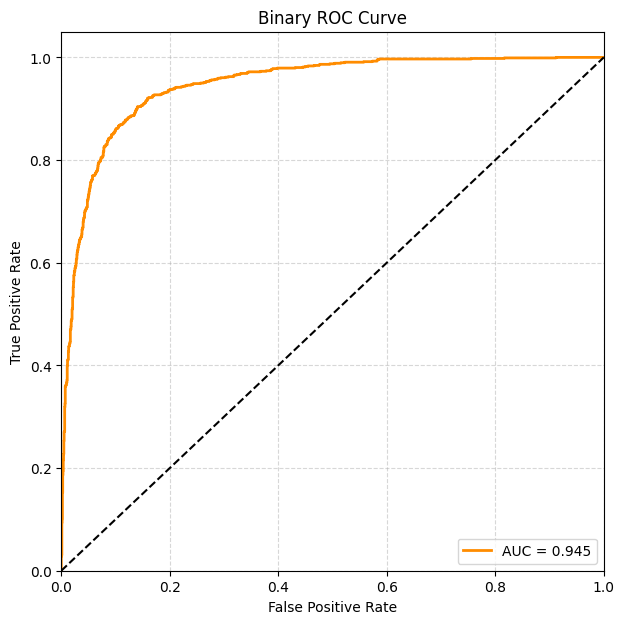


AUC = 0.9453


In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
input_dim = X_test.shape[1]
num_classes = 2

model = HybridNODEAttentionModel(dim=input_dim, num_classes=num_classes)
model.load_state_dict(torch.load(OUT_MODEL, map_location='cpu'))
model = model.to(device)
model.eval()

probs_all = []
y_true = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out = model(xb)
        probs = F.softmax(out, dim=1).cpu().numpy()
        probs_all.append(probs)
        y_true.extend(yb.numpy())

probs_all = np.vstack(probs_all)
y_true = np.array(y_true)
y_score = probs_all[:, 1]

fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, lw=2, color='darkorange', label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Binary ROC Curve")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="lower right")
plt.show()

print(f"\nAUC = {roc_auc:.4f}")

### Find threshold

In [14]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import (
    f1_score, accuracy_score, precision_score, recall_score,
    balanced_accuracy_score, confusion_matrix, classification_report
)
from torch.utils.data import DataLoader, TensorDataset

test_dataset = TensorDataset(
    torch.from_numpy(X_test.astype(np.float32)),
    torch.from_numpy(y_test.astype(np.int64))
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

prob_af = []
true_labels = []

model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out = model(xb)
        probs = F.softmax(out, dim=1).cpu().numpy()
        prob_af.extend(probs[:, 1])
        true_labels.extend(yb.numpy())

prob_af = np.array(prob_af)
true_labels = np.array(true_labels)

print("Probability range:", prob_af.min(), "-", prob_af.max())
print("Label distribution (0=SR, 1=AF):", np.bincount(true_labels))


Probability range: 8.141701e-05 - 0.9593041
Label distribution (0=SR, 1=AF): [1912  960]


In [17]:
coarse = np.arange(0.0, 1.01, 0.05)
fine = np.arange(0.50, 0.601, 0.01)
candidates = np.unique(np.concatenate([coarse, fine]))

f1s, accs, precs, recs = [], [], [], []

for t in candidates:
    preds = (prob_af >= t).astype(int)
    f1s.append(f1_score(true_labels, preds))
    accs.append(accuracy_score(true_labels, preds))
    precs.append(precision_score(true_labels, preds, zero_division=0))
    recs.append(recall_score(true_labels, preds))

scores = [(f1s[i] + accs[i]) / 2 for i in range(len(candidates))]
best_idx = np.argmax(scores)
best_t = candidates[best_idx]

print(f"\nBest threshold = {best_t:.3f}")
print(f"F1={f1s[best_idx]:.4f}, Acc={accs[best_idx]:.4f}, "
      f"Prec={precs[best_idx]:.4f}, Rec={recs[best_idx]:.4f}")



Best threshold = 0.580
F1=0.8344, Acc=0.8886, Prec=0.8292, Rec=0.8396


In [18]:
# --- Show all thresholds with F1 and Accuracy ---
print("\n========== Threshold Summary ==========")
print(f"{'Threshold':<10} {'F1':<10} {'Accuracy':<10}")
print("-" * 35)

for i, t in enumerate(candidates):
    print(f"{t:<10.2f} {f1s[i]:<10.4f} {accs[i]:<10.4f}")




========== Threshold Summary ==========
Threshold  F1         Accuracy  
-----------------------------------
0.00       0.5010     0.3343    
0.05       0.5693     0.4958    
0.10       0.6119     0.5773    
0.15       0.6300     0.6090    
0.20       0.6415     0.6299    
0.25       0.6743     0.6821    
0.30       0.7300     0.7597    
0.35       0.7568     0.7939    
0.40       0.7821     0.8238    
0.45       0.8128     0.8572    
0.50       0.8260     0.8740    
0.51       0.8246     0.8740    
0.52       0.8275     0.8767    
0.53       0.8291     0.8795    
0.54       0.8332     0.8837    
0.55       0.8337     0.8851    
0.56       0.8340     0.8865    
0.57       0.8332     0.8872    
0.58       0.8344     0.8886    
0.59       0.8315     0.8875    
0.60       0.8291     0.8872    
0.65       0.8131     0.8830    
0.70       0.7799     0.8691    
0.75       0.7187     0.8458    
0.80       0.6299     0.8130    
0.85       0.5175     0.7792    
0.90       0.3551     0.7357    

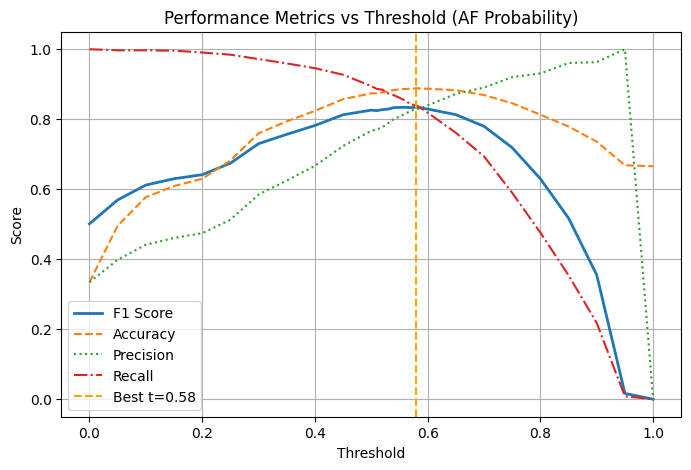

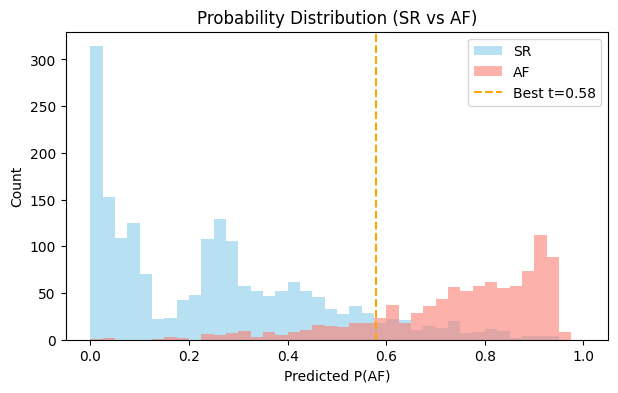

In [19]:
plt.figure(figsize=(8,5))
plt.plot(candidates, f1s, label="F1 Score", linewidth=2)
plt.plot(candidates, accs, label="Accuracy", linestyle="--")
plt.plot(candidates, precs, label="Precision", linestyle=":")
plt.plot(candidates, recs, label="Recall", linestyle="-.")
plt.axvline(best_t, color="orange", linestyle="--", label=f"Best t={best_t:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Performance Metrics vs Threshold (AF Probability)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(7,4))
plt.hist(prob_af[true_labels==0], bins=40, range=(0,1), alpha=0.6, label="SR", color="skyblue")
plt.hist(prob_af[true_labels==1], bins=40, range=(0,1), alpha=0.6, label="AF", color="salmon")
plt.axvline(best_t, color="orange", linestyle="--", label=f"Best t={best_t:.2f}")
plt.xlabel("Predicted P(AF)")
plt.ylabel("Count")
plt.title("Probability Distribution (SR vs AF)")
plt.legend()
plt.show()
